In [42]:
from __future__ import print_function

import sys
import numpy as np
from time import time
import matplotlib.pyplot as plt

sys.path.append('/home/xilinx')
from pynq import Overlay
from pynq import allocate

https://discuss.pynq.io/t/pynq-z1-ip-or-hierarchy-not-found-in-overlay/2056/9

> you will not find the ... IP because it does not have an AXI4 memory mapped interface.

In [62]:
ol = Overlay("./FINN_colored_stream.bit")
for ip in ol.ip_dict: print(ip)
for hier in ol.hierarchy_dict: print(hier)

ipDMAInOut = ol.axi_dma_0

axi_dma_0
zynq_ps


In [63]:
bsize = 10; i = 9
n_batches = int(10000 / bsize)
ishape_packed = (bsize, 32, 32, 3, 1)
oshape_packed = (bsize, 1, 1)

test_imgs = np.load("testx.npy").reshape(n_batches, bsize, -1)
test_labels = np.load("testy.npy").reshape(n_batches, bsize)

inBuffer0 = allocate(shape=ishape_packed, dtype=np.uint8, cacheable=True)
outBuffer0 = allocate(shape=oshape_packed, dtype=np.uint8, cacheable=True)

In [64]:
np.copyto(inBuffer0, test_imgs[i].reshape(ishape_packed))
inBuffer0.flush()

https://discuss.pynq.io/t/running-fft-with-axi-dma-channel-wait-dma-channel-not-started/1479

> It seems that the problem was the size of the FIFO in combination with buffer register width of the DMA. making both of these sufficiently large I can now run ... in non-realtime mode. 

In [65]:
timeKernelStart = time()
#if ipDMAInOut.sendchannel.idle:
#    ipDMAInOut.sendchannel.transfer(inBuffer0)
#else: print("In Busy")
#if ipDMAInOut.sendchannel.idle:
#    ipDMAInOut.recvchannel.transfer(outBuffer0)
#else: print("Out Busy")
ipDMAInOut.sendchannel.transfer(inBuffer0)
ipDMAInOut.recvchannel.transfer(outBuffer0)

#if ipDMAInOut.sendchannel.running:
#    ipDMAInOut.sendchannel.wait()
#if ipDMAInOut.recvchannel.running:
#    ipDMAInOut.recvchannel.wait()
timeKernelEnd = time()
print("Kernel execution time: " + str(timeKernelEnd - timeKernelStart) + " s")

Kernel execution time: 0.001989603042602539 s


In [66]:
classes = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

obuf_normal = np.empty_like(outBuffer0)
outBuffer0.invalidate()
np.copyto(obuf_normal, outBuffer0)

In [67]:
print("Result:", list(map(lambda i: classes[i], obuf_normal.flatten())))
print("Golden:", list(map(lambda i: classes[i], test_labels[i].flatten())))
nok, ok = np.bincount(obuf_normal.flatten() == test_labels[i].flatten())
print("total OK %d NOK %d" % (ok, nok))

Result: ['airplane', 'cat', 'ship', 'frog', 'deer', 'frog', 'frog', 'airplane', 'airplane', 'horse']
Golden: ['airplane', 'cat', 'ship', 'frog', 'deer', 'frog', 'frog', 'airplane', 'airplane', 'horse']
total OK 10 NOK 0


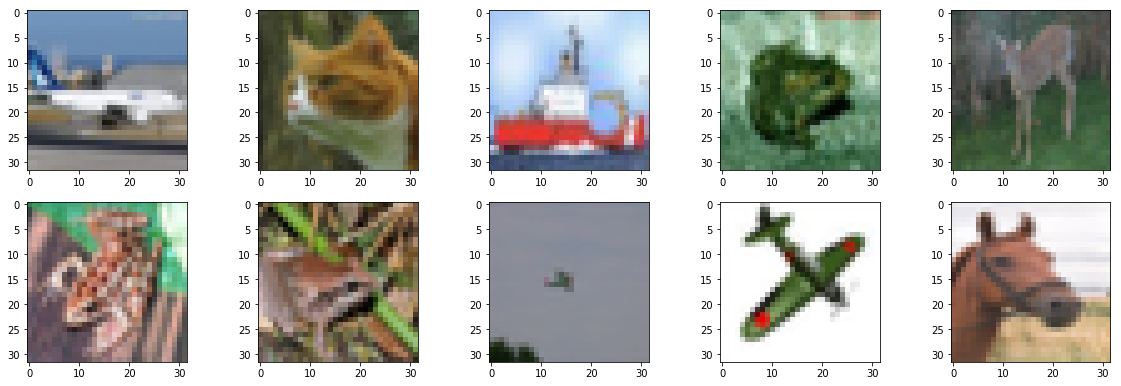

In [68]:
plt.figure(figsize=(20,10))
columns = 5
if bsize <= 25:
    for i, image in enumerate(inBuffer0.reshape((bsize,32,32,3))):
        plt.subplot(bsize / columns + 1, columns, i + 1)
        plt.imshow(image)

In [ ]:
print("============================")
print("Exit process")